## 1.Environment Setup & Imports

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define path
data_path = '../datasets/student_grade.csv'

In [12]:
df = pd.read_csv(data_path, low_memory=False)
df

,cohort,acad_year,term,year_level,room,student_id,GEN223 DISASTER PREPAREDNESS,INT102 WEB TECHNOLOGY,INT20101 JAVASCRIPT PROGRAMMING,INT203 CLIENT-SIDE WEB PROGRAMMING II,...,INT491 SPECIAL TOPICS I : MULTIMEDIA TECHNOLOGY,INT492 SPECIAL TOPICS II : BUSINESS FINANCE AND DATA ANALYTICS,INT492 SPECIAL TOPICS II : DEVSECOPS,GEN354 DIGITAL PRODUCT INNOVATION AND COMMERCIALIZATION,INT530 SELECTED TOPICS IN INFRASTRUCTURE : INTERNET SECURITY (HANDS-ON APPROACH),INT540 SELECTED TOPICS IN INFORMATION TECHNOLOGY : DECISION SUPPORT SYSTEMS,LNG323 ENGLISH FOR DIGITAL SERVICE INNOVATION,SSC263 DEVELOPING LEADERS,INT420 BIG DATA ANALYTICS,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION
0,66,2567,2,3,A,A375,0.0,0,0.0,2.5,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
1,66,2567,2,3,A,A335,0.0,0,0.0,3.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
2,66,2567,2,3,A,A381,0.0,0,0.0,2.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
3,66,2567,2,3,A,A286,0.0,0,0.0,2.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
4,66,2567,2,3,A,A515,0.0,0,2.5,2.5,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,63,2563,2,4,A,A442,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
4299,63,2563,2,4,A,A479,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
4300,63,2563,2,4,A,A545,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0
4301,63,2563,2,4,A,A658,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0


## 2.Data Loading & Preprocessing

In [ ]:
# === 2.1 Load Data ===
df = pd.read_csv(data_path, low_memory=False)

# === 2.2 Transform Data (Wide to Long) ===
id_vars = ['student_id']
df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

# === 2.3 Clean Data ===
# Convert grade to numeric and remove invalid/empty grades
df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

# === 2.4 Filter for 'INT' Courses Only ===
# This ensures the model only learns from INT courses
df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

print(f"--- Data Preparation Complete ---")
print(f"Total records after cleaning: {len(df_long_cleaned)}")
print(f"Filtered to INT courses only: {len(df_long_filtered)}")
display(df_long_filtered)

# === 2.5 Advanced Data Filtering ===
MIN_GRADES_PER_STUDENT = 5   # นักเรียนต้องมีเกรดอย่างน้อย 5 วิชา (ถ้าน้อยกว่านี้ Model จะเดานิสัยยาก)
MIN_STUDENTS_PER_COURSE = 10 # วิชานั้นต้องมีคนเรียนอย่างน้อย 10 คน (ถ้าน้อยกว่านี้ Model จะไม่รู้นิสัยวิชา)

print(f"\n--- Starting Advanced Filtering ---")
print(f"Original Count: {len(df_long_filtered)}")

# 1. กรองนักเรียนที่มีข้อมูลน้อยออก
student_counts = df_long_filtered['student_id'].value_counts()
valid_students = student_counts[student_counts >= MIN_GRADES_PER_STUDENT].index
df_step1 = df_long_filtered[df_long_filtered['student_id'].isin(valid_students)]
print(f"After removing students with < {MIN_GRADES_PER_STUDENT} grades: {len(df_step1)}")

# 2. กรองวิชาที่มีข้อมูลน้อยออก
course_counts = df_step1['course'].value_counts()
valid_courses = course_counts[course_counts >= MIN_STUDENTS_PER_COURSE].index
df_final = df_step1[df_step1['course'].isin(valid_courses)].copy()
print(f"After removing courses with < {MIN_STUDENTS_PER_COURSE} students: {len(df_final)}")

# === 2.6 Summary ===
print(f"\n--- Final Data for Modeling ---")
print(f"Total records: {len(df_final)}")
print(f"Unique Students: {df_final['student_id'].nunique()}")
print(f"Unique Courses: {df_final['course'].nunique()}")


--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
25871,A246,INT102 WEB TECHNOLOGY,1.5
27143,A632,INT102 WEB TECHNOLOGY,3.0
27144,A086,INT102 WEB TECHNOLOGY,4.0
27145,A662,INT102 WEB TECHNOLOGY,4.0
27146,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
592988,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
592990,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593003,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593005,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5



--- Starting Advanced Filtering ---
Original Count: 17468
After removing students with < 5 grades: 17412
After removing courses with < 10 students: 17380

--- Final Data for Modeling ---
Total records: 17380
Unique Students: 647
Unique Courses: 48


## 3.Split Data to train and test set


In [21]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
# Normal Filtered Data
# data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)
# Advanced Filtered Data
data = Dataset.load_from_df(df_final[['student_id', 'course', 'grade']], reader)


# # === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (NMF)

In [ ]:
print("--- Training SVD Model ---")
model = NMF(
    n_factors = 130,
    n_epochs  = 90,
    reg_pu    = 0.04,
    reg_qi   = 0.08,
    random_state = 42
)
model = NMF(
    n_factors = 130,
    n_epochs  = 110,
    reg_pu    = 0.04,
    reg_qi   = 0.04,
    random_state = 42
)
model.fit(trainset)
print("Training complete.")



--- Training SVD Model ---
Training complete.


## 5.Test and evaluate model

In [23]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


--- Model Evaluation ---
RMSE: 0.5668
MAE:  0.4487


## 6.Confusion Matrix Classification_report 8 grades

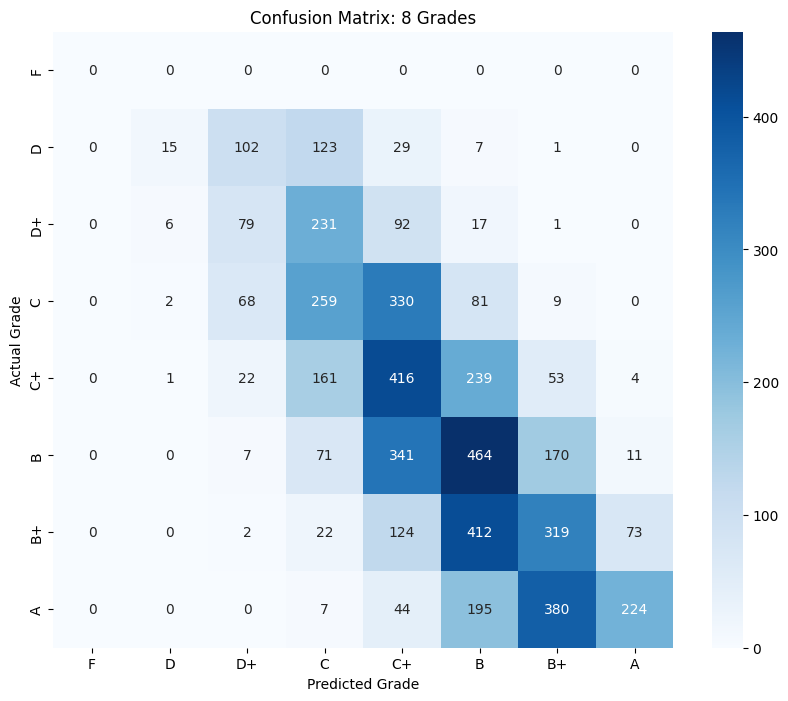

--- 8-Grade Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.62      0.05      0.10       277
          D+       0.28      0.19      0.22       426
           C       0.30      0.35      0.32       749
          C+       0.30      0.46      0.37       896
           B       0.33      0.44      0.37      1064
          B+       0.34      0.34      0.34       952
           A       0.72      0.26      0.39       850

    accuracy                           0.34      5214
   macro avg       0.36      0.26      0.26      5214
weighted avg       0.40      0.34      0.33      5214

------------------------------------------------------------
Model Performance Summary:
1. Strict Accuracy (Exact Match):       34.06%
2. Adjacent Accuracy (Within +/-1 step): 82.26%
------------------------------------------------------------
Note: มีจำนวน 2513 เคส ที่โมเดลทายผิดไปเพียง 1 ขั้นเกรด


In [ ]:
# Mapping: 8 Grades
score_to_letter_8 = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}
valid_scores_8 = sorted(score_to_letter_8.keys())
valid_labels_8 = [score_to_letter_8[s] for s in valid_scores_8]

def get_nearest_grade_8(score):
    return min(valid_scores_8, key=lambda x: abs(x - score))

y_true_8 = [score_to_letter_8[get_nearest_grade_8(p.r_ui)] for p in predictions]
y_pred_8 = [score_to_letter_8[get_nearest_grade_8(p.est)] for p in predictions]


# Adjacent Accuracy
def calculate_relaxed_metrics(y_true, y_pred, labels):
    # สร้าง Map เกรดเป็นตัวเลขลำดับ (F=0, D=1, D+=2, ...)
    label_map = {label: i for i, label in enumerate(labels)}
    
    correct = 0
    adjacent = 0
    total = len(y_true)
    
    for t, p in zip(y_true, y_pred):
        if t in label_map and p in label_map:
            diff = abs(label_map[t] - label_map[p])
            
            if diff == 0:
                correct += 1
            elif diff <= 1: # ยอมรับความคลาดเคลื่อน +/- 1 ขั้น
                adjacent += 1
                
    strict_acc = correct / total
    relaxed_acc = (correct + adjacent) / total
    
    return strict_acc, relaxed_acc, adjacent

# Confusion Matrix 8 grades
plt.figure(figsize=(10, 8))
cm_8 = confusion_matrix(y_true_8, y_pred_8, labels=valid_labels_8)

# Plot heatmap
sns.heatmap(cm_8, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels_8, yticklabels=valid_labels_8)
plt.title('Confusion Matrix: 8 Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# Classification + Relaxed Accuracy
print("--- 8-Grade Classification Report ---")
print(classification_report(y_true_8, y_pred_8, target_names=valid_labels_8, labels=valid_labels_8, zero_division=0))

# คำนวณและแสดงผล Adjacent Accuracy
strict_acc, relaxed_acc, adj_count = calculate_relaxed_metrics(y_true_8, y_pred_8, valid_labels_8)

print("-" * 60)
print(f"Model Performance Summary:")
print(f"1. Strict Accuracy (Exact Match):       {strict_acc:.2%}")
print(f"2. Adjacent Accuracy (+/-1 step): {relaxed_acc:.2%}")
print("-" * 60)
print(f"Note: มีจำนวน {adj_count} เคส ที่โมเดลทายผิดไปเพียง 1 ขั้นเกรด")


## 6.1 Confusion Matrix Classification_report 5 grades


--- 5-Grade Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.66      0.29      0.40       703
           C       0.52      0.71      0.60      1645
           B       0.58      0.68      0.63      2016
           A       0.72      0.26      0.39       850

    accuracy                           0.57      5214
   macro avg       0.50      0.39      0.40      5214
weighted avg       0.59      0.57      0.55      5214



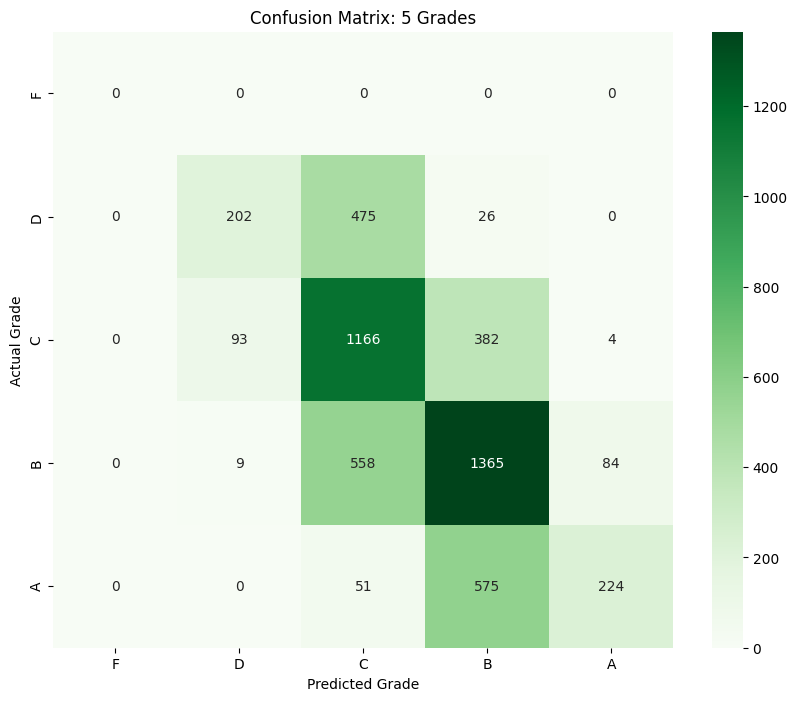

In [25]:
# Mapping: 5 Grades (Collapsing Plus grades)
score_to_letter_5 = {
    0.0: 'F', 
    1.0: 'D', 1.5: 'D', 
    2.0: 'C', 2.5: 'C',
    3.0: 'B', 3.5: 'B', 
    4.0: 'A'
}
valid_labels_5 = ['F', 'D', 'C', 'B', 'A']
# We still check against the full range of possible scores
valid_scores_all = [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

y_true_5 = [score_to_letter_5[get_nearest_grade_8(p.r_ui)] for p in predictions]
y_pred_5 = [score_to_letter_5[get_nearest_grade_8(p.est)] for p in predictions]

# Plot Heatmap 5 Grades
plt.figure(figsize=(10, 8))
cm_5 = confusion_matrix(y_true_5, y_pred_5, labels=valid_labels_5)
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Greens', xticklabels=valid_labels_5, yticklabels=valid_labels_5)
plt.title('Confusion Matrix: 5 Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')

print("\n--- 5-Grade Classification Report ---")
print(classification_report(y_true_5, y_pred_5, target_names=valid_labels_5, labels=valid_labels_5, zero_division=0))

## 6.2 Confusion Matrix Classification_report

In [19]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)

# ----- Regression metrics -----
rmse = accuracy.rmse(predictions, verbose=False)
mae  = accuracy.mae(predictions, verbose=False)

# ดึงค่าจริง/ค่าทำนายออกมา
y_true = [p.r_ui for p in predictions]   # actual grade
y_pred = [p.est  for p in predictions]   # predicted grade

r2 = r2_score(y_true, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

# ----- Classification-style metrics -----
# แปลงเป็น high / low ด้วย threshold เช่น >= 2.5 = class 1
threshold = 3.0  # หรือ 3.0 ถ้าอยากโหดขึ้น

y_true_cls = [1 if y >= threshold else 0 for y in y_true]
y_pred_cls = [1 if y >= threshold else 0 for y in y_pred]

# Macro = ให้น้ำหนักทุก class เท่ากัน
precision_macro = precision_score(y_true_cls, y_pred_cls, average='macro')
recall_macro    = recall_score(y_true_cls, y_pred_cls, average='macro')
f1_macro        = f1_score(y_true_cls, y_pred_cls, average='macro')

# Weighted = ถ่วงตามสัดส่วนคลาส (ถ้า class imbalance)
precision_weighted = precision_score(y_true_cls, y_pred_cls, average='weighted')
recall_weighted    = recall_score(y_true_cls, y_pred_cls, average='weighted')
f1_weighted        = f1_score(y_true_cls, y_pred_cls, average='weighted')

print("\n--- Classification Metrics ---")
print(f"Precision (macro)   : {precision_macro:.4f}")
print(f"Recall    (macro)   : {recall_macro:.4f}")
print(f"F1-score  (macro)   : {f1_macro:.4f}")

print(f"\nPrecision (weighted): {precision_weighted:.4f}")
print(f"Recall    (weighted): {recall_weighted:.4f}")
print(f"F1-score  (weighted): {f1_weighted:.4f}")



--- Model Evaluation ---
RMSE : 0.5723
MAE  : 0.4517
R²   : 0.5522

--- Classification Metrics ---
Precision (macro)   : 0.7694
Recall    (macro)   : 0.7504
F1-score  (macro)   : 0.7305

Precision (weighted): 0.7830
Recall    (weighted): 0.7327
F1-score  (weighted): 0.7280


## R-score 

In [26]:
y_true_raw = [pred.r_ui for pred in predictions]
y_pred_raw = [pred.est for pred in predictions]

y_pred_rounded = [np.round(pred.est * 2) / 2 for pred in predictions]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)
r2Rounded = r2_score(y_true_raw, y_pred_rounded)


print(f"R2 Score: {r2:.4f}")
print(f"R2 Score Rounded: {r2Rounded:.4f}")

R2 Score: 0.5717
R2 Score Rounded: 0.5459
